In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

In [2]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

### Analyze by describing data

In [3]:
train_df.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [4]:
train_df[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


In [5]:
train_df[['Sex', 'Survived']].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


In [6]:
train_df[['SibSp', 'Survived']].groupby(['SibSp'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,SibSp,Survived
1,1,0.535885
2,2,0.464286
0,0,0.345395
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


In [7]:
train_df[['Parch', 'Survived']].groupby(['Parch'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Parch,Survived
3,3,0.600000
1,1,0.550847
2,2,0.500000
0,0,0.343658
5,5,0.200000
4,4,0.000000
6,6,0.000000


### Features

In [8]:
train_df.loc[(train_df["Cabin"].isna()),"Cabin"] = 0
train_df.loc[(train_df["Cabin"]!=0),"Cabin"] = 1
test_df.loc[(test_df["Cabin"].isna()),"Cabin"] = 0
test_df.loc[(test_df["Cabin"]!=0),"Cabin"] = 1

In [9]:
train_df = train_df.rename(columns = {"Cabin":"HasCabin"})
test_df = test_df.rename(columns = {"Cabin":"HasCabin"})

In [10]:
comb_df = [train_df, test_df]

In [11]:
for dataset in comb_df:
    dataset['Sex'] = dataset['Sex'].map( {'female': 1, 'male': 0} ).astype(int)

In [12]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,HasCabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,0,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,1,C
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,0,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,1,S
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,0,S


In [13]:
sex_class_mean_age = train_df.groupby(["Sex","Pclass"]).aggregate({"Age":"mean"}).reset_index()
for dataset in comb_df:
    for sex in [0,1]:
        for pclass in [1,2,3]:
            dataset.loc[(dataset.Sex == sex) & (dataset.Pclass == pclass) & (dataset.Age.isna()),'Age'] = \
            sex_class_mean_age.loc[(sex_class_mean_age.Sex == sex) & (sex_class_mean_age.Pclass == pclass),'Age'].iloc[0]
    dataset['Age'] = dataset['Age'].astype(int)
#train_df.loc[(train_df["Sex"] == True)&(train_df["Age"].isna()),"Age"] = round(sex_mean_age.male.iloc[0])
#train_df.loc[(train_df["Sex"] == False)&(train_df["Age"].isna()),"Age"] = round(sex_mean_age.female.iloc[0])

In [14]:
sex_class_mean_age

,Sex,Pclass,Age
0,0,1,41.281386
1,0,2,30.740707
2,0,3,26.507589
3,1,1,34.611765
4,1,2,28.722973
5,1,3,21.750000


In [15]:
train_df['Embarked'] = train_df['Embarked'].fillna(train_df['Embarked'].mode()[0])
train_df['Embarked'] = train_df['Embarked'].map({"S":0,"C":1,"Q":2})

In [16]:
test_df['Embarked'] = test_df['Embarked'].fillna(test_df['Embarked'].mode()[0])
test_df['Embarked'] = test_df['Embarked'].map({"S":0,"C":1,"Q":2})


In [17]:
train_df = train_df.drop(["Ticket"],axis=1)
test_df = test_df.drop(["Ticket"],axis=1)

In [18]:
train_df = train_df.drop(["Name"],axis=1)
test_df = test_df.drop(["Name"],axis=1)

In [19]:
comb_df = [train_df,test_df]

In [20]:
train_df['Agecath'] = pd.cut(train_df['Age'], 5)
train_df[['Agecath', 'Survived']].groupby(['Agecath'], as_index=False).mean().sort_values(by='Agecath', ascending=True)

/tmp/ipykernel_25885/1073789734.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  train_df[['Agecath', 'Survived']].groupby(['Agecath'], as_index=False).mean().sort_values(by='Agecath', ascending=True)


,Agecath,Survived
0,"(-0.08, 16.0]",0.550000
1,"(16.0, 32.0]",0.337374
2,"(32.0, 48.0]",0.412037
3,"(48.0, 64.0]",0.434783
4,"(64.0, 80.0]",0.090909


In [21]:
for dataset in comb_df:    
    dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age']
train_df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,HasCabin,Embarked,Agecath
0,1,0,3,0,1,1,0,7.2500,0,0,"(16.0, 32.0]"
1,2,1,1,1,2,1,0,71.2833,1,1,"(32.0, 48.0]"
2,3,1,3,1,1,0,0,7.9250,0,0,"(16.0, 32.0]"
3,4,1,1,1,2,1,0,53.1000,1,0,"(32.0, 48.0]"
4,5,0,3,0,2,0,0,8.0500,0,0,"(32.0, 48.0]"


In [22]:
train_df = train_df.drop("Agecath",axis=1)
comb_df = [train_df, test_df]

In [23]:
train_df['FareBand'] = pd.qcut(train_df['Fare'], 4)
train_df[['FareBand', 'Survived']].groupby(['FareBand'], as_index=False).mean().sort_values(by='FareBand', ascending=True)

/tmp/ipykernel_25885/2916669673.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  train_df[['FareBand', 'Survived']].groupby(['FareBand'], as_index=False).mean().sort_values(by='FareBand', ascending=True)


,FareBand,Survived
0,"(-0.001, 7.91]",0.197309
1,"(7.91, 14.454]",0.303571
2,"(14.454, 31.0]",0.454955
3,"(31.0, 512.329]",0.581081


In [24]:
train_df['Fare'].fillna(train_df['Fare'].dropna().median(), inplace=True)
test_df['Fare'].fillna(test_df['Fare'].dropna().median(), inplace=True)
for dataset in comb_df:
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)

train_df = train_df.drop(['FareBand'], axis=1)
comb_df = [train_df, test_df]
train_df.head()

/tmp/ipykernel_25885/469840784.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df['Fare'].fillna(train_df['Fare'].dropna().median(), inplace=True)
/tmp/ipykernel_25885/469840784.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(va

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,HasCabin,Embarked
0,1,0,3,0,1,1,0,0,0,0
1,2,1,1,1,2,1,0,3,1,1
2,3,1,3,1,1,0,0,1,0,0
3,4,1,1,1,2,1,0,3,1,0
4,5,0,3,0,2,0,0,1,0,0


In [25]:
for dataset in comb_df:
    dataset["Alone"] = 1
    dataset.loc[dataset["SibSp"]+dataset["Parch"] > 0,'Alone'] = 0

In [26]:
train_df = train_df.drop(["SibSp","Parch"],axis=1)
test_df = test_df.drop(["SibSp","Parch"],axis=1) 

In [27]:
comf_df = [train_df,test_df]

In [28]:
train_df.head()

,PassengerId,Survived,Pclass,Sex,Age,Fare,HasCabin,Embarked,Alone
0,1,0,3,0,1,0,0,0,0
1,2,1,1,1,2,3,1,1,0
2,3,1,3,1,1,1,0,0,1
3,4,1,1,1,2,3,1,0,0
4,5,0,3,0,2,1,0,0,1


### Classification

In [29]:
X_train = train_df.drop("Survived",axis=1)
y_train = train_df.Survived

In [30]:
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size = 0.25)

In [31]:
X_train.head()

,PassengerId,Pclass,Sex,Age,Fare,HasCabin,Embarked,Alone
743,744,3,0,1,2,0,0,0
639,640,3,0,1,2,0,0,0
103,104,3,0,2,1,0,0,1
533,534,3,1,1,2,0,1,0
671,672,1,0,1,3,1,0,0


### Logistic regression

In [33]:
logist = LogisticRegression()
logist.fit(X_train,y_train)
y_pred_logist = logist.predict(X_val)
print("F1 Score on validation data:", f1_score(y_val, y_pred_logist))

F1 Score on validation data: 0.7282608695652174


/home/vadimpp/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Tree

In [55]:
tree = DecisionTreeClassifier()
param_grid={
    "criterion":["gini","entropy"],
    "max_depth":range(1,10)
}
search = GridSearchCV(tree, param_grid=param_grid, cv=5)

In [56]:
search.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(1, 10)})

In [57]:
best_tree = search.best_estimator_

In [58]:

y_pred_tree = best_tree.predict(X_val)
print("F1 Score on validation data:", f1_score(y_val, y_pred_tree))

F1 Score on validation data: 0.7125


## KNN

In [59]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(algorithm='ball_tree')
knn_param_grid={"n_neighbors":range(1,100)}
knn_search = GridSearchCV(knn, param_grid=knn_param_grid, cv=5)

In [60]:
knn_search.fit(X_train[["Age","Sex","Pclass","Fare","Alone"]],y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(algorithm='ball_tree'),
             param_grid={'n_neighbors': range(1, 100)})

In [61]:
best_knn = knn_search.best_estimator_

In [63]:

y_val_pred = best_knn.predict(X_val[["Age","Sex","Pclass","Fare","Alone"]])
print("F1 Score on validation data:", f1_score(y_val, y_val_pred))

F1 Score on validation data: 0.7108433734939759


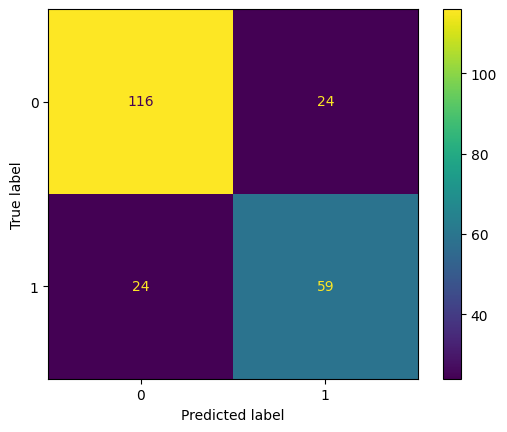

In [64]:
cm_knn = confusion_matrix(y_val,y_val_pred)
ConfusionMatrixDisplay(cm_knn).plot()

### Ensemble methods

In [65]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import RandomizedSearchCV
from random import randint

In [66]:
param_dist = {'n_estimators': range(10,500),
              'max_depth': range(1,10)}

# Create a random forest classifier
rf = RandomForestClassifier()

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter=5, 
                                 cv=5)

In [67]:
rand_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=5,
                   param_distributions={'max_depth': range(1, 10),
                                        'n_estimators': range(10, 500)})

In [68]:
best_rf = rand_search.best_estimator_

In [69]:
y_pred = best_rf.predict(X_val)
print("F1 Score on validation data:", f1_score(y_val, y_pred))

F1 Score on validation data: 0.718562874251497


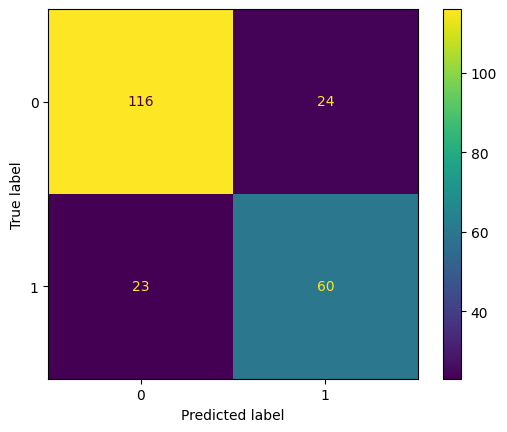

In [70]:
cm = confusion_matrix(y_val,y_pred)
ConfusionMatrixDisplay(cm).plot()

In [152]:
estimators = [
    ("tr",best_tree),
    ("rf",best_rf)
]
voting = VotingClassifier(estimators=estimators, voting='soft')
voting.fit(X_train, y_train)

VotingClassifier(estimators=[('tr',
                              DecisionTreeClassifier(criterion='entropy',
                                                     max_depth=5)),
                             ('rf',
                              RandomForestClassifier(max_depth=19,
                                                     n_estimators=430))],
                 voting='soft')

In [153]:
voting_y_pred = voting.predict(X_val)
print("F1 Score on validation data:", f1_score(y_val, voting_y_pred))

F1 Score on validation data: 0.7325581395348837


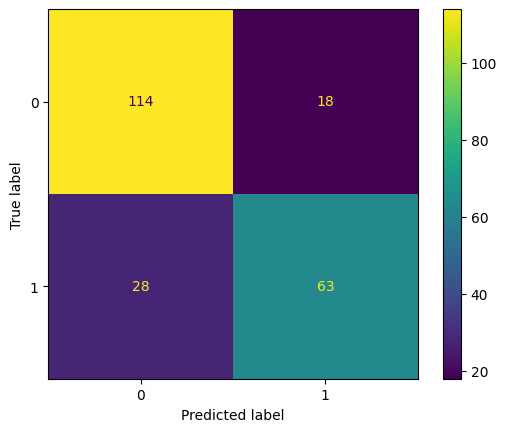

In [154]:
cm = confusion_matrix(y_val,voting_y_pred)
ConfusionMatrixDisplay(cm).plot()